## Missing values in each of the water body overview

In [236]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

In [237]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [238]:
data_path = "/content/drive/MyDrive/PK Data Science/master/codes/water_availability_prediction_in_Italy/data/"

In [239]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## River_Arno

Information about Arno river. The Arno is the second largest river in peninsular Italy and the main waterway in Tuscany and it  has a relatively torrential regime, 
due to the nature of the surrounding soils (marl and impermeable clays)

Output: Hydrometry_Nave_di_Rosano

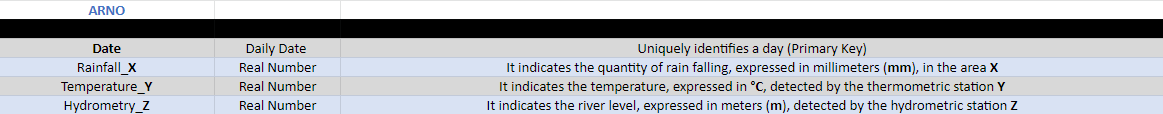

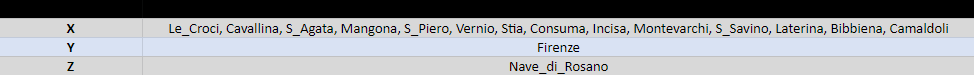

In [240]:
river_arno_csv_name = "River_Arno.csv"
df = pd.read_csv(data_path+river_arno_csv_name)

In [241]:
df.columns.size

17

In [242]:
df.describe()

,Rainfall_Le_Croci,Rainfall_Cavallina,Rainfall_S_Agata,Rainfall_Mangona,Rainfall_S_Piero,Rainfall_Vernio,Rainfall_Stia,Rainfall_Consuma,Rainfall_Incisa,Rainfall_Montevarchi,Rainfall_S_Savino,Rainfall_Laterina,Rainfall_Bibbiena,Rainfall_Camaldoli,Temperature_Firenze,Hydrometry_Nave_di_Rosano
count,6026.000000,6026.000000,6026.000000,6026.000000,6026.000000,4283.000000,1283.000000,1283.000000,4568.000000,1647.000000,1283.00000,1283.000000,2378.000000,1283.000000,6192.000000,8169.000000
mean,3.129871,2.674743,2.670063,3.340657,2.471225,3.416437,2.538893,3.416680,2.335026,2.056709,2.42650,2.101949,2.640959,3.826968,16.605386,1.472407
std,8.025121,7.655847,7.166643,8.903134,6.650012,9.425358,6.502917,8.938863,6.347652,6.117967,7.23414,6.377879,7.161416,9.591337,7.458951,0.616259
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,-2.700000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,10.650000,1.100000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,16.350000,1.300000
75%,1.200000,0.600000,1.200000,1.400000,0.800000,1.200000,1.000000,2.200000,0.800000,0.600000,0.70000,0.400000,1.200000,2.400000,22.700000,1.690000
max,88.400000,113.600000,120.200000,110.000000,80.600000,126.000000,63.000000,114.400000,102.200000,75.000000,123.20000,95.600000,77.400000,103.600000,34.900000,6.750000


In [243]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8217 entries, 0 to 8216
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8217 non-null   object 
 1   Rainfall_Le_Croci          6026 non-null   float64
 2   Rainfall_Cavallina         6026 non-null   float64
 3   Rainfall_S_Agata           6026 non-null   float64
 4   Rainfall_Mangona           6026 non-null   float64
 5   Rainfall_S_Piero           6026 non-null   float64
 6   Rainfall_Vernio            4283 non-null   float64
 7   Rainfall_Stia              1283 non-null   float64
 8   Rainfall_Consuma           1283 non-null   float64
 9   Rainfall_Incisa            4568 non-null   float64
 10  Rainfall_Montevarchi       1647 non-null   float64
 11  Rainfall_S_Savino          1283 non-null   float64
 12  Rainfall_Laterina          1283 non-null   float64
 13  Rainfall_Bibbiena          2378 non-null   float

In [244]:
df.isnull().sum()

Date                            0
Rainfall_Le_Croci            2191
Rainfall_Cavallina           2191
Rainfall_S_Agata             2191
Rainfall_Mangona             2191
Rainfall_S_Piero             2191
Rainfall_Vernio              3934
Rainfall_Stia                6934
Rainfall_Consuma             6934
Rainfall_Incisa              3649
Rainfall_Montevarchi         6570
Rainfall_S_Savino            6934
Rainfall_Laterina            6934
Rainfall_Bibbiena            5839
Rainfall_Camaldoli           6934
Temperature_Firenze          2025
Hydrometry_Nave_di_Rosano      48
dtype: int64

In [245]:
df

,Date,Rainfall_Le_Croci,Rainfall_Cavallina,Rainfall_S_Agata,Rainfall_Mangona,Rainfall_S_Piero,Rainfall_Vernio,Rainfall_Stia,Rainfall_Consuma,Rainfall_Incisa,Rainfall_Montevarchi,Rainfall_S_Savino,Rainfall_Laterina,Rainfall_Bibbiena,Rainfall_Camaldoli,Temperature_Firenze,Hydrometry_Nave_di_Rosano
0,01/01/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.82
1,02/01/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.94
2,03/01/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.11
3,04/01/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.84
4,05/01/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8212,26/06/2020,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.34
8213,27/06/2020,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.21
8214,28/06/2020,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.30
8215,29/06/2020,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.19


In [246]:
df.index = pd.to_datetime(df.Date)

In [247]:
df

,Date,Rainfall_Le_Croci,Rainfall_Cavallina,Rainfall_S_Agata,Rainfall_Mangona,Rainfall_S_Piero,Rainfall_Vernio,Rainfall_Stia,Rainfall_Consuma,Rainfall_Incisa,Rainfall_Montevarchi,Rainfall_S_Savino,Rainfall_Laterina,Rainfall_Bibbiena,Rainfall_Camaldoli,Temperature_Firenze,Hydrometry_Nave_di_Rosano
Date,,,,,,,,,,,,,,,,,
1998-01-01,01/01/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.82
1998-02-01,02/01/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.94
1998-03-01,03/01/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.11
1998-04-01,04/01/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.84
1998-05-01,05/01/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-26,26/06/2020,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.34
2020-06-27,27/06/2020,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.21
2020-06-28,28/06/2020,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.30


In [248]:
df=df.drop(['Date'], axis=1)

In [249]:
df

,Rainfall_Le_Croci,Rainfall_Cavallina,Rainfall_S_Agata,Rainfall_Mangona,Rainfall_S_Piero,Rainfall_Vernio,Rainfall_Stia,Rainfall_Consuma,Rainfall_Incisa,Rainfall_Montevarchi,Rainfall_S_Savino,Rainfall_Laterina,Rainfall_Bibbiena,Rainfall_Camaldoli,Temperature_Firenze,Hydrometry_Nave_di_Rosano
Date,,,,,,,,,,,,,,,,
1998-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.82
1998-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.94
1998-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.11
1998-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.84
1998-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-26,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.34
2020-06-27,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.21
2020-06-28,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.30


In [250]:
def feature_engineering(df):
    df["Day"] = df.index.day
    df["Month"] = df.index.month
    df["Year"] = df.index.year
    df["DayOfYear"] = df.index.dayofyear
    
    return df

In [251]:
df.index.min(), df.index.max()

(Timestamp('1998-01-01 00:00:00'), Timestamp('2020-12-06 00:00:00'))

In [252]:
df_date_range = pd.date_range(start='1998-01-01', end='2020-12-06')
list_of_missing_dates = df_date_range.difference(df.index)
df_missing = pd.DataFrame(index=list_of_missing_dates, columns=df.columns)

In [253]:
df_with_missing = pd.concat([df, df_missing])

df_all = feature_engineering(df_with_missing)

In [254]:
df_2008 = df_all.loc[df_all['Year'].isin([2008])]
df_2008.isnull().sum()

Rainfall_Le_Croci              0
Rainfall_Cavallina             0
Rainfall_S_Agata               0
Rainfall_Mangona               0
Rainfall_S_Piero               0
Rainfall_Vernio                0
Rainfall_Stia                366
Rainfall_Consuma             366
Rainfall_Incisa                0
Rainfall_Montevarchi         179
Rainfall_S_Savino            366
Rainfall_Laterina            366
Rainfall_Bibbiena              0
Rainfall_Camaldoli           366
Temperature_Firenze            0
Hydrometry_Nave_di_Rosano      1
Day                            0
Month                          0
Year                           0
DayOfYear                      0
dtype: int64

In [255]:
df_2020 = df_all.loc[df_all['Year'].isin([2020])]
df_2020.isnull().sum()

Rainfall_Le_Croci            159
Rainfall_Cavallina           159
Rainfall_S_Agata             159
Rainfall_Mangona             159
Rainfall_S_Piero             159
Rainfall_Vernio              341
Rainfall_Stia                341
Rainfall_Consuma             341
Rainfall_Incisa              341
Rainfall_Montevarchi         341
Rainfall_S_Savino            341
Rainfall_Laterina            341
Rainfall_Bibbiena            341
Rainfall_Camaldoli           341
Temperature_Firenze          341
Hydrometry_Nave_di_Rosano    160
Day                            0
Month                          0
Year                           0
DayOfYear                      0
dtype: int64

In [256]:
df_all.index.max() - df_all.index.min()

Timedelta('8375 days 00:00:00')

In [275]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8376 entries, 1998-01-01 to 2020-12-06
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Rainfall_Le_Croci          6026 non-null   float64
 1   Rainfall_Cavallina         6026 non-null   float64
 2   Rainfall_S_Agata           6026 non-null   float64
 3   Rainfall_Mangona           6026 non-null   float64
 4   Rainfall_S_Piero           6026 non-null   float64
 5   Rainfall_Vernio            4283 non-null   float64
 6   Rainfall_Stia              1283 non-null   float64
 7   Rainfall_Consuma           1283 non-null   float64
 8   Rainfall_Incisa            4568 non-null   float64
 9   Rainfall_Montevarchi       1647 non-null   float64
 10  Rainfall_S_Savino          1283 non-null   float64
 11  Rainfall_Laterina          1283 non-null   float64
 12  Rainfall_Bibbiena          2378 non-null   float64
 13  Rainfall_Camaldoli         128

In [276]:
df_all.isnull().sum()

Rainfall_Le_Croci            2350
Rainfall_Cavallina           2350
Rainfall_S_Agata             2350
Rainfall_Mangona             2350
Rainfall_S_Piero             2350
Rainfall_Vernio              4093
Rainfall_Stia                7093
Rainfall_Consuma             7093
Rainfall_Incisa              3808
Rainfall_Montevarchi         6729
Rainfall_S_Savino            7093
Rainfall_Laterina            7093
Rainfall_Bibbiena            5998
Rainfall_Camaldoli           7093
Temperature_Firenze          2184
Hydrometry_Nave_di_Rosano     207
Day                             0
Month                           0
Year                            0
DayOfYear                       0
dtype: int64

In [274]:
df_all = df_all.sort_index()
fig = px.line(df_all, x="DayOfYear", y="Hydrometry_Nave_di_Rosano", animation_frame="Year", markers=True)
fig.update_traces(connectgaps=False)
fig.update_yaxes(range=[-0.5, 6.8])
fig.show()

In [264]:
df_2008 = df_2008.sort_index()
fig = px.line(df_2008, x=df_2008.index , y="Hydrometry_Nave_di_Rosano", markers=True)
fig.update_traces(connectgaps=False)
fig.update_layout(hovermode="x unified")
fig.update_xaxes(showspikes=True)
fig.update_yaxes(showspikes=True)
fig.show()

In [265]:
df_2020 = df_2020.sort_index()
fig = px.line(df_2020, x=df_2020.index , y="Hydrometry_Nave_di_Rosano", markers=True)
fig.update_traces(connectgaps=False)
fig.update_layout(hovermode="x unified")
fig.update_xaxes(showspikes=True)
fig.update_yaxes(showspikes=True)
fig.show()

In [260]:
fig = px.scatter(df_all, x="DayOfYear", y="Hydrometry_Nave_di_Rosano", animation_frame="Year")
fig.update_traces(connectgaps=False)
fig.show()

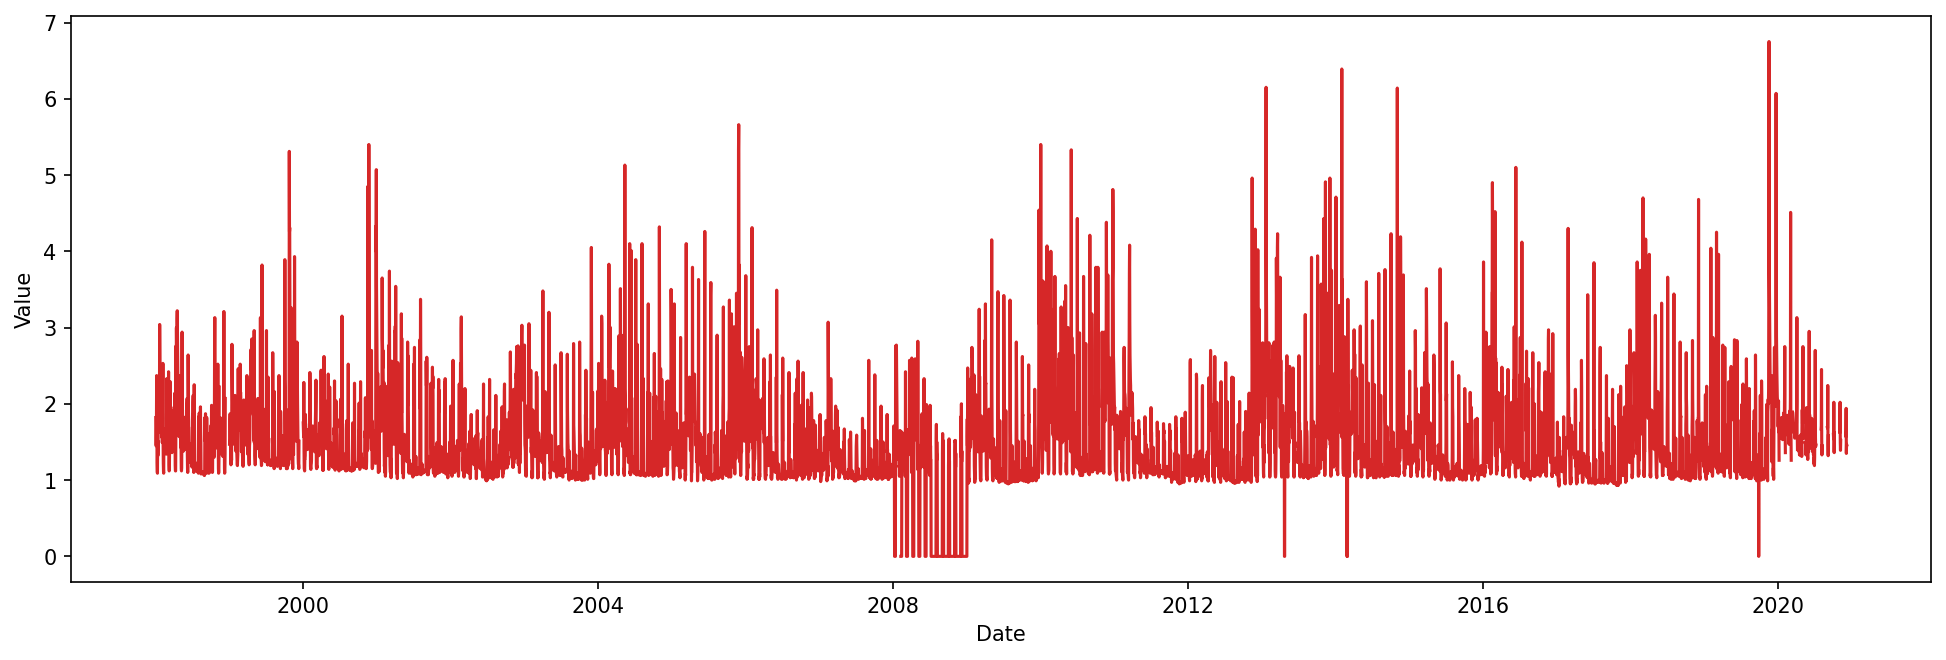

In [261]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=150):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df_all, x=df_all.index, y=df_all.Hydrometry_Nave_di_Rosano, title='')    

In [281]:
!git config --global user.email "gancarz.hanna@gmail.com"

In [283]:
!git commit -m "filled df in rows with Nan values so as to discard missing dates in time series of River Arno"


On branch master
Your branch is up to date with 'origin/master'.

Changes not staged for commit:
	modified:   River Arno.ipynb

no changes added to commit
